Approach
1) standardize model naming conventions
2) fix models times 
3) regrid all models to global 1x1 degree grid 
4) apply precalculated area matrix
5) calculate variables 

ISSUES:

- some models don't have grids (just strings of lat, lon) (AWI, GISS, ICON?)
- some models don't want to be regridded (EC-EArth, IPSL-LR, MPI-HR
- some models are missing siconc data (KACE, MCM)
- some models don't want to open (NESM23)


- **still need to get the corresponding SSP5-8.5 projections to capture the rest of the observational period**
- **still need to get daily data**

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
from shapely.geometry import box as BOX
import datetime
import xesmf as xe

### data downloaded

In [1]:
def unite_data(thick_file, conc_file, timeslice = []):
    
    # open files
    if len(thick_file) > 1:
        ds1 = xr.open_mfdataset(thick_file)
        ds2 = xr.open_mfdataset(conc_file)
    else:
        ds1 = xr.open_dataset(thick_file[0])
        ds2 = xr.open_dataset(conc_file[0])
    
    # limit time window
    if timeslice:
        ds1 = ds1.sel(time = slice(timeslice[0], timeslice[1]))
        ds2 = ds2.sel(time = slice(timeslice[0], timeslice[1]))
    else:
        pass
    
    # unite data
    if ds2.siconc.max() > 1:
        ds1['siconc'] = ds2.siconc/100
    else:
        ds1['siconc'] = ds2.siconc
    
    return ds1

In [3]:
def parse_data(ds):
    
    # get list of coordinate and dimension keys
    old_coord_keys = list(ds.coords.keys())
    old_dim_keys = list(ds.dims.keys())
    
    # rename to standard set of named keys (t --> time, (i, ni) --> x, (j, nj) --> y, lat --> latitude, lon --> longitude)
    standard = [None]*4
    if 'i' in old_dim_keys:
        standard[0] = 'i'
        standard[1] = 'j'
    elif 'ni' in old_dim_keys:
        standard[0] = 'ni'
        standard[1] = 'nj'
    else:
        standard[0] = 'x'
        standard[1] = 'y'
        
    if 'latitude' in old_coord_keys:
        standard[2] = 'latitude'
        standard[3] = 'longitude'
    elif 'nav_lat' in old_coord_keys:
        standard[2] = 'nav_lat'
        standard[3] = 'nav_lon'
    else:
        standard[2] = 'lat'
        standard[3] = 'lon'
    
    ds = ds.rename({standard[0]:'x', 
                    standard[1]:'y',
                    standard[2]:'lat',
                    standard[3]:'lon'})
    
    # drop bad dimension keys
    dim_keys = list(ds.dims.keys()) 
    bad_dim_keys = [key for key in dim_keys if key not in ['x','y','time']]
    ds = ds.drop_dims(bad_dim_keys)
    
    # drop bad coordinate keys
    coord_keys = list(ds.coords.keys())
    bad_coord_keys = [key for key in coord_keys if key not in ['lat','lon','time']]
    ds = ds.drop(bad_coord_keys)
    
    # drop unneccessary variables
    var_keys = list(ds.variables.keys())
    bad_var_keys = [key for key in var_keys if key not in ['sithick', 'siconc','lat','lon','time']]
    ds = ds.drop(bad_var_keys)
        
    # transpose to (time, x, y)
    ds = ds.transpose('time','y','x')
    
    return ds

In [42]:
def correct_time_and_loc(ds, years):
    
    # correct time
    init_time = datetime.datetime(years[0],1,15)

    model_times = []
    for x in range(years[0],years[1]):
        for y in range(1,13):
            model_times.append(datetime.datetime(x,y,15))

    ds['time'] = model_times
    
    # correct longitude and latitude
    ds['lon'] = ds.lon.where(ds.lon < 180, ds.lon - 360)
    ds['lat'] = ds.lat.where(ds.lat < 90)
    ds['lat'] = ds.lat.where(ds.lat > -90)
    
    ds = regrid(ds)
    
    area = xr.open_dataset('xESMF_1x1_grid_area.nc')
    ds['grid_area'] = (('y','x'),area.area.data)
    
    return ds

In [32]:
def regrid(ds_in):

    ds_out = xe.util.grid_global(1, 1)
    regridder = xe.Regridder(ds_in, ds_out, "bilinear")
    ds = regridder(ds_in)
    
    return ds

In [6]:
def get_variables(ds, region = 'Arctic'):
    
    ds = ds.where(ds.grid_area > 0)
    
    # limit to region of choice
    if region == 'Arctic':
        ds = ds.where(ds.lat > 50)
    elif region == 'Antarctic':
        ds = ds.where(ds.lat < -50)
    elif region == 'both':
        pass
    else:
        AssertionError('incorrect region input!')
    
    # limit to where there is ice 
    ds = ds.where(ds.siconc > 0)
    
    # calculate 
    Sea_Ice_Area = ds.siconc * ds.grid_area
    Sea_Ice_Volume = ds.sithick * Sea_Ice_Area
    SIA = Sea_Ice_Area.sum(dim = ['x','y'])
    SIV = Sea_Ice_Volume.sum(dim = ['x','y'])
    
    # reassign
    ds['siarea'] = Sea_Ice_Area
    ds['sivol'] = Sea_Ice_Volume
    ds['SIA'] = SIA
    ds['SIV'] = SIV
    
    return ds

In [7]:
# bad_models =  ['AWI-ESM-1-1-LR', 'E3SM-1-0',,'GISS-E2-2-G','GISS-E2-2-H','ICON-ESM-LR','KACE-1-0-G','MCM-UA-1-0','NESM3','EC-Earth3-Veg', 'EC-Earth3','EC-Earth3-AerChem','IPSL-CM6A-LR-INCA','MPI-ESM1-2-HR',]

In [8]:
models = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'CESM2-FV2', 'CESM2-WACCM-FV2', 'CESM2', 'CMCC-CM2-SR5', 
          'CMCC-ESM2', 'GFDL-CM4','GFDL-ESM4','IPSL-CM5A2-INCA','MPI-ESM-1-2-HAM','MPI-ESM1-2-LR','TaiESM1']

In [49]:
timescale = [2010,2015]
for model in models:
    thick_files = sorted(glob.glob('/glade/work/mollyw/Projects/sea_ice_covariability/data/cmip6/data/v_sithick_*_'+model+'_*/*.nc'))
    conc_files = sorted(glob.glob('/glade/work/mollyw/Projects/sea_ice_covariability/data/cmip6/data/v_siconc_*_'+model+'_*/*.nc'))
    
    ds = unite_data(thick_files, conc_files, timeslice = ['2010-01-01', '2022-01-01'])
    ds = parse_data(ds)
    ds = correct_time_and_loc(ds, timescale)
    ds = get_variables(ds)
    
    ds.to_netcdf(model+'_'+str(timescale[0])+'-'+str(timescale[1])+'_1x1.nc')
    
    print(model, ' processing complete!')

MPI-ESM1-2-LR  processing complete!
TaiESM1  processing complete!


### XMIP

In [2]:
col = google_cmip_col()

ImportError: This functionality requires intake-esm. Install with `conda install -c conda-forge intake-esm

### Get xESMF grid area info

In [19]:
def lat_lon_cell_area(lat_lon_grid_cell):
    """
    Calculate the area of a cell, in meters^2, on a lat/lon grid.
    
    This applies the following equation from Santinie et al. 2010.
    
    S = (λ_2 - λ_1)(sinφ_2 - sinφ_1)R^2
    
    S = surface area of cell on sphere
    λ_1, λ_2, = bands of longitude in radians
    φ_1, φ_2 = bands of latitude in radians
    R = radius of the sphere
    
    Santini, M., Taramelli, A., & Sorichetta, A. (2010). ASPHAA: A GIS‐Based 
    Algorithm to Calculate Cell Area on a Latitude‐Longitude (Geographic) 
    Regular Grid. Transactions in GIS, 14(3), 351-377.
    https://doi.org/10.1111/j.1467-9671.2010.01200.x

    Parameters
    ----------
    lat_lon_grid_cell
        A shapely box with coordinates on the lat/lon grid

    Returns
    -------
    float
        The cell area in meters^2

    """
    from numpy import radians, cos, sin
    
    # mean earth radius - https://en.wikipedia.org/wiki/Earth_radius#Mean_radius
    AVG_EARTH_RADIUS_METERS = 6371008.8
    
    west, south, east, north = lat_lon_grid_cell.bounds
    
    if abs(west - east) > 300:
        west = west + 360
        # print(east)
    
    west = radians(west)
    east = radians(east)
    south = radians(south)
    north = radians(north)
    
    return (east - west) * (sin(north) - sin(south)) * (AVG_EARTH_RADIUS_METERS**2)

In [26]:
# area = np.zeros([len(ds.x),len(ds.y)])
area = np.zeros([len(ds.y),len(ds.x)])
for y in range(0, len(ds.y)-1):
    for x in range(0,len(ds.x)-1):
        lat1 = ds.lat[y][x]
        lat2 = ds.lat[y+1][x+1]
     
        
        lon1 = ds.lon[y][x]
        lon2 = ds.lon[y+1][x+1]
        
        if lon1 < lon2 and lat2 < lat1:
            box = BOX(lon2, lat1, lon1, lat2)
        elif lon1 < lon2 and lat1 < lat2:
            box = BOX(lon2, lat2, lon1, lat1)
        elif lon2 < lon1 and lat1 < lat2:
            box = BOX(lon1, lat2, lon2, lat1)
        else:
            box = BOX(lon1, lat1, lon2, lat2)
        
        area[y,x] = lat_lon_cell_area(box)

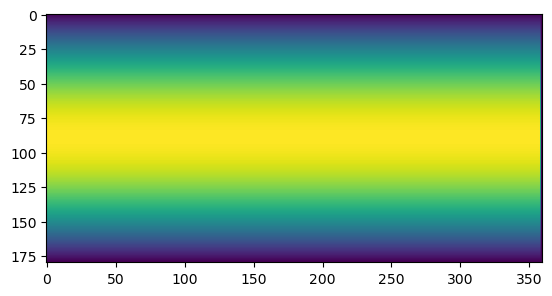

In [27]:
plt.imshow(area)

In [28]:
area_ds = xr.Dataset(data_vars=dict(
                     area=(["y", "x",], area))
                     )

In [30]:
area_ds.to_netcdf('xESMF_1x1_grid_area.nc')